In [45]:
import os, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Tuple, Dict, Iterable
from torch_geometric.data import Batch

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)
rng = np.random.default_rng(7)

# Config 

In [47]:
@dataclass
class SimCfg:
    R: float = 200.0
    P_max: float = 200.0
    S_L: float = 1.0
    S_W: float = 0.75
    c_price: float = 0.1
    B: float = 10**6
    n0: float = None         
    Fs: int = 3                
    K: int = 3             
    N: int = 5

In [48]:
def pathloss_gain(d):
    return -(120.9 + 37.6 * np.log10(d / 1000.0)) + 7 * np.random.normal(1, size=d.shape)

In [49]:
def calculate_channel_matrix(distances, is_bs: bool):
    d = distances.reshape(-1, 1) if is_bs else distances
    pathloss = pathloss_gain(d)
    small_scale = np.random.normal(1, size=d.shape) ** 2
    channel_gain = 10 ** (pathloss / 10.0) * small_scale
    return np.abs(channel_gain).astype(np.float32)

In [50]:
class StandardScalerNP:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(0)
        self.std_ = X.std(0)
        self.std_[self.std_==0]=1.0
    def transform(self, X): return (X-self.mean_)/self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# Generate dataset 

In [51]:
# # -------------------------------
# # Environment Setup
# # -------------------------------
# R = 200
# P_max = 200
# S_L = 1         # LTE satisfaction per unit rate
# S_W = 0.75      # WiFi satisfaction per unit rate



# c = 0.1         # Cost per unit data rate
# B = 10**6       # Bandwidth
# n0 = B * 10**-17.4  # Noise power

# F = 3          # Number of subchannels
# K = 3           # Number of WiFi APs
# N = 5           # Number of users

# bs_location = np.array([R, R])
# user_locations = []
# ap_locations = []
# C_i = []         # User affordability
# L_thr = []       # Satisfaction thresholds

# # Random affordability for 40% of users
# selected_users = set(random.sample(range(N), int(N * 0.4)))

# for i in range(N):
#     L_thr.append(0.3)
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     user_locations.append([x, y])
#     C = np.random.uniform(5, 10) if i in selected_users else 0
#     C_i.append(C)

# for i in range(K):
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     ap_locations.append([x, y])

# user_locations = np.array(user_locations)
# ap_locations = np.array(ap_locations)

# # -------------------------------
# # Channel Calculation
# # -------------------------------

# def calculate_channel_matrix(distances, is_bs):
#     if is_bs:
#         distances = distances.reshape(-1, 1)
#     pathloss = -(120.9 + 37.6 * np.log10(distances / 1000)) + \
#                7 * np.random.normal(1, size=distances.shape)
#     small_scale = np.random.normal(1, size=distances.shape)**2
#     channel_gain = 10 ** (pathloss / 10) * small_scale
#     return np.abs(channel_gain)

# d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations, axis=2)
# d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)
# h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)
# h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()

# # -------------------------------
# # Random Fixed Assignments: X, Ψ, q
# # -------------------------------

# X_iL = np.zeros(N)
# X_ik = np.zeros((N, K))
# Psi = np.zeros((N, F))
# q = np.random.randint(0, 2, N)  # Random satisfaction indicator

# for i in range(N):
#     sel = np.random.choice(K + 1)
#     if sel == K:
#         X_iL[i] = 1
#     else:
#         X_ik[i, sel] = 1
#     Psi[i, np.random.choice(F)] = 1

## HomoGraph

In [ ]:
# def generate_dataset(cfg: SimCfg, seed: int = 7, standardize: bool = True):
#     random.seed(seed)
#     n0 = cfg.B * 10**-17.4 if (cfg.n0 is None) else cfg.n0
#     bs_location = np.array([cfg.R, cfg.R], dtype=np.float32)

#     user_locations, ap_locations = [], []
#     C_i, L_thr = [], []
#     selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * 0.4))))

#     for i in range(cfg.N):
#         L_thr.append(0.3)
#         x, y = np.random.uniform(0, 2 * cfg.R, size=2)
#         user_locations.append([x, y])
#         C = np.random.uniform(5, 10) if i in selected_users else 0.0
#         C_i.append(C)

#     for i in range(cfg.K):
#         x, y = np.random.uniform(0, 2 * cfg.R, size=2)
#         ap_locations.append([x, y])

#     user_locations = np.array(user_locations, dtype=np.float32)
#     ap_locations   = np.array(ap_locations,   dtype=np.float32)
#     C_i  = np.array(C_i,  dtype=np.float32)
#     L_thr= np.array(L_thr,dtype=np.float32)

#     # -------------------------------
#     # Channel Calculation
#     # -------------------------------

#     d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations[None, :], axis=2)  # (N,K)
#     d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)                     # (N,)
#     h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)                               # (N,K)
#     h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()                      # (N,)

#     # -------------------------------
#     # Random Fixed Assignments: X, Ψ, q
#     # -------------------------------
#     X_iL = np.zeros(cfg.N, dtype=np.int64)
#     X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)
#     Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)
#     q    = np.random.randint(0, 2, cfg.N).astype(np.int64)  # Random satisfaction indicator

#     subband_idx = np.zeros(cfg.N, dtype=np.int64)
#     ap_idx      = -np.ones(cfg.N, dtype=np.int64)  # -1 nếu LTE

#     for i in range(cfg.N):
#         sel = np.random.choice(cfg.K + 1)  # {0..K-1}=AP, K=LTE
#         if sel == cfg.K:
#             X_iL[i] = 1
#             ap_idx[i] = -1
#         else:
#             X_ik[i, sel] = 1
#             ap_idx[i] = sel
#         f = np.random.choice(cfg.Fs)
#         Psi[i, f] = 1
#         subband_idx[i] = f

#     # -------------------------------
#     # Interference matrix Hbar
#     Hbar = np.zeros((cfg.N, cfg.N), dtype=np.float32)
#     for i in range(cfg.N):
#         if X_iL[i] == 1:
#             Hbar[i, :] = h_iL[:]
#         else:
#             kstar = ap_idx[i]
#             Hbar[i, :] = h_ik[:, kstar]
#     np.fill_diagonal(Hbar, 0.0)

#     # -------------------------------
#     # Build graph edges
#     # -------------------------------
#     P_vec = np.full(cfg.N, cfg.P_max, dtype=np.float32) 
#     edge_src, edge_dst, edge_w = [], [], []
#     for f in range(cfg.Fs):
#         ids = np.where(subband_idx == f)[0]
#         if ids.size <= 1:
#             continue
#         for a in ids:
#             for b in ids:
#                 if a == b: 
#                     continue
#                 w = P_vec[b] * Hbar[a, b]
#                 edge_src.append(a); edge_dst.append(b); edge_w.append(float(w))

#     edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
#     edge_weight = torch.tensor(edge_w, dtype=torch.float32)


#     feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
#     df = pd.DataFrame({
#         "Pmax": P_vec,
#         "Ci":   C_i,
#         "Lthr": L_thr,
#         "h_iL": h_iL
#     })
#     for k in range(cfg.K):
#         df[f"h_i{k}"] = h_ik[:, k]
#     df["subband"] = subband_idx
#     df["x_LTE"]   = X_iL
#     df["ap_idx"]  = ap_idx
#     df["q"]       = q

#     X_np = df[feat_cols].to_numpy(np.float32)
#     if standardize:
#         X_mean = X_np.mean(axis=0); X_std = X_np.std(axis=0); X_std[X_std == 0] = 1.0
#         X_np = (X_np - X_mean) / X_std

#     # if standardize:
#     #     X_mean = X_np.mean(axis=0)
#     #     X_std  = X_np.std(axis=0)
#     #     X_std[X_std == 0] = 1.0
#     #     ci_idx = feat_cols.index("Ci")
#     #     X_mean[ci_idx] = 0.0  
#     #     X_std[ci_idx]  = 1.0 

#     data = Data(
#         x=torch.tensor(X_np, dtype=torch.float32),
#         edge_index=edge_index,
#         edge_weight=edge_weight
#     )

#     aux = {
#         "g_iL": torch.tensor(h_iL, dtype=torch.float32),
#         "g_ik": torch.tensor(h_ik, dtype=torch.float32),
#         "Pmax": torch.tensor(np.full(cfg.N, cfg.P_max, dtype=np.float32), dtype=torch.float32),
#         "Ci":   torch.tensor(C_i, dtype=torch.float32),
#         "Lthr": torch.tensor(L_thr, dtype=torch.float32),
#         "noise": torch.tensor(float(n0), dtype=torch.float32),
#         "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
#         "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
#         "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),
#         "N": cfg.N, "K": cfg.K, "F": cfg.Fs,
#         "X_iL": torch.tensor(X_iL, dtype=torch.int64),
#         "X_ik": torch.tensor(X_ik, dtype=torch.int64),
#         "Psi":  torch.tensor(Psi,  dtype=torch.int64),
#         "q":    torch.tensor(q,    dtype=torch.int64),
#         "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
#         "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),
#         "user_xy": torch.tensor(user_locations, dtype=torch.float32),
#         "ap_xy":   torch.tensor(ap_locations,   dtype=torch.float32),
#         "bs_xy":   torch.tensor([cfg.R, cfg.R], dtype=torch.float32)
#     }

#     return df, data, aux


In [ ]:
# def build_fixed_batches(cfg, num_scenarios=1000, batch_size=64, start_seed=7, standardize: bool = True):
#     scenarios = []
#     for i in range(num_scenarios):
#         seed = start_seed + i
#         df_i, data_i, aux_i = generate_dataset(cfg, seed=seed, standardize = standardize)
#         scenarios.append((df_i, data_i, aux_i))

#     batches = []
#     for start in range(0, len(scenarios), batch_size):
#         chunk = scenarios[start:start+batch_size]
#         data_list = [d for (_, d, _) in chunk]
#         aux_list  = [a for (_, _, a) in chunk]
#         batched = Batch.from_data_list(data_list)     
#         batches.append((batched, aux_list))

#     return batches

## HetoGraph

In [412]:
import numpy as np
import random
import torch
from torch_geometric.data import HeteroData
import pandas as pd

def generate_dataset_bipartite(cfg, seed: int = 7, standardize: bool = True):
    """
    Bipartite System Model:
      - Nodes:
          * user: N nodes, feat = [Pmax, Ci, Lthr]
          * infra: (K+1) nodes, feat = [is_LTE] (index 0: LTE, 1..K: AP_k)
      - Edges (undirected by adding both dirs):
          * user <-> infra, edge_attr = large-scale channel gain
      - Keep compatibility variables in aux (association/subband placeholders).
    Returns:
      df:   per-user table incl. Pmax, Ci, Lthr, h_iL, h_i0..h_i(K-1)
      data: HeteroData graph
      aux:  dict with full set of variables (incl. placeholders)
    """
    rng = np.random.default_rng(seed)
    random.seed(seed)

    # -------------------------------
    # Noise
    # -------------------------------
    n0 = cfg.B * 10**-17.4 if (getattr(cfg, "n0", None) is None) else cfg.n0

    # -------------------------------
    # Geometry
    # -------------------------------
    bs_xy = np.array([cfg.R, cfg.R], dtype=np.float32)
    ap_xy = rng.uniform(0, 2 * cfg.R, size=(cfg.K, 2)).astype(np.float32)
    user_xy = rng.uniform(0, 2 * cfg.R, size=(cfg.N, 2)).astype(np.float32)

    # -------------------------------
    # Channels (large-scale gains)
    # -------------------------------
    d_user_bs = np.linalg.norm(user_xy - bs_xy[None, :], axis=1)                # (N,)
    d_user_ap = np.linalg.norm(user_xy[:, None, :] - ap_xy[None, :, :], axis=2) # (N,K)

    # Reuse your channel function for consistency
    h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).astype(np.float32).flatten()   # (N,)
    h_ik = calculate_channel_matrix(d_user_ap, is_bs=False).astype(np.float32)            # (N,K)

    C_i, L_thr = [], []
    selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * 0.4))))

    for i in range(cfg.N):
        L_thr.append(0.3)
        C = np.random.uniform(5, 10) if i in selected_users else 0.0
        C_i.append(C)

    C_i  = np.array(C_i,  dtype=np.float32)
    L_thr= np.array(L_thr,dtype=np.float32)
    Pmax_users = np.full(cfg.N, cfg.P_max, dtype=np.float32)


    data = HeteroData()

    # user.x = [Pmax, Ci, Lthr]
    u_user = np.stack([Pmax_users, C_i, L_thr], axis=1).astype(np.float32)
    if standardize:
        mu = u_user.mean(axis=0); std = u_user.std(axis=0); std[std == 0] = 1.0
        u_user = (u_user - mu) / std
    data["user"].x = torch.tensor(u_user, dtype=torch.float32)
    data["user"].pos = torch.tensor(user_xy, dtype=torch.float32)

    # infra.x = [is_LTE]
    # index 0: LTE, 1..K: APs
    u_infra = np.concatenate([np.array([[1.0]], dtype=np.float32),
                              np.zeros((cfg.K, 1), dtype=np.float32)], axis=0)
    infra_xy = np.vstack([bs_xy[None, :], ap_xy]).astype(np.float32)
    data["infra"].x = torch.tensor(u_infra, dtype=torch.float32)
    data["infra"].pos = torch.tensor(infra_xy, dtype=torch.float32)

    # Edges: user --link-- infra (undirected by adding reverse)
    edge_src_u = []
    edge_dst_m = []
    edge_gain  = []

    # LTE edge (m = 0)
    for i in range(cfg.N):
        edge_src_u.append(i); edge_dst_m.append(0); edge_gain.append(float(h_iL[i]))
    # AP edges (m = 1..K)
    for i in range(cfg.N):
        for k in range(cfg.K):
            edge_src_u.append(i); edge_dst_m.append(1 + k); edge_gain.append(float(h_ik[i, k]))

    src = torch.tensor(edge_src_u, dtype=torch.long)
    dst = torch.tensor(edge_dst_m, dtype=torch.long)
    gain = torch.tensor(edge_gain, dtype=torch.float32).view(-1, 1)

    data["user", "link", "infra"].edge_index = torch.stack([src, dst], dim=0)
    data["user", "link", "infra"].edge_attr  = gain
    data["infra", "rev_link", "user"].edge_index = torch.stack([dst, src], dim=0)
    data["infra", "rev_link", "user"].edge_attr  = gain

    # -------------------------------
    # df (per-user table) — giống cấu trúc cũ để tiện dùng
    # -------------------------------
    feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
    df = pd.DataFrame({
        "uid": np.arange(cfg.N, dtype=np.int64),
        "Pmax": Pmax_users,
        "Ci":   C_i,
        "Lthr": L_thr,
        "h_iL": h_iL,
        "x": user_xy[:, 0].astype(np.float32),
        "y": user_xy[:, 1].astype(np.float32),
    })
    for k in range(cfg.K):
        df[f"h_i{k}"] = h_ik[:, k].astype(np.float32)

    # -------------------------------
    # Placeholders for association/subband (to keep API compatible)
    # -------------------------------
    # Not decided yet at System Model stage:
    X_iL = np.zeros(cfg.N, dtype=np.int64)            # 0/1, all 0 now
    X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)   # all zeros
    Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)  # all zeros
    q    = np.zeros(cfg.N, dtype=np.int64)            # all zeros
    subband_idx = np.zeros(cfg.N, dtype=np.int64)     # default 0
    ap_idx      = -np.ones(cfg.N, dtype=np.int64)     # -1 meaning "unknown"

    # -------------------------------
    # aux (full, compatible)
    # -------------------------------
    aux = {
        # channels
        "g_iL": torch.tensor(h_iL, dtype=torch.float32),
        "g_ik": torch.tensor(h_ik, dtype=torch.float32),

        # power / service
        "Pmax": torch.tensor(Pmax_users, dtype=torch.float32),
        "Ci":   torch.tensor(C_i, dtype=torch.float32),
        "Lthr": torch.tensor(L_thr, dtype=torch.float32),
        "noise": torch.tensor(float(n0), dtype=torch.float32),
        "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
        "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
        "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),

        # sizes
        "N": cfg.N, "K": cfg.K, "F": cfg.Fs,

        # placeholders (still provided for compatibility)
        "X_iL": torch.tensor(X_iL, dtype=torch.int64),
        "X_ik": torch.tensor(X_ik, dtype=torch.int64),
        "Psi":  torch.tensor(Psi,  dtype=torch.int64),
        "q":    torch.tensor(q,    dtype=torch.int64),
        "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
        "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),

        # geometry
        "user_xy": torch.tensor(user_xy, dtype=torch.float32),
        "ap_xy":   torch.tensor(ap_xy,   dtype=torch.float32),
        "bs_xy":   torch.tensor(bs_xy,   dtype=torch.float32),
    }

    return df[["uid"] + feat_cols + ["x", "y"]], data, aux


In [ ]:
from typing import List, Tuple
import torch
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader

def build_fixed_batches_bipartite(
    cfg,
    num_scenarios: int = 1000,
    batch_size: int = 64,
    start_seed: int = 7,
    standardize: bool = True
):
    scenarios = []
    for i in range(num_scenarios):
        seed = start_seed + i
        df_i, data_i, aux_i = generate_dataset_bipartite(
            cfg, seed=seed, standardize=standardize
        )
        scenarios.append((data_i, aux_i))

    batches = []

    data_list = [d for (d, _) in scenarios]           
    aux_list_all = [a for (_, a) in scenarios]       
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

    for b_idx, batched_graph in enumerate(loader):
        start = b_idx * batch_size
        end = min(start + batch_size, len(aux_list_all))
        aux_chunk = aux_list_all[start:end]
        batches.append((batched_graph, aux_chunk))

    return batches

In [416]:
cfg = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=None, Fs=3, K=3, N=5)
batches = build_fixed_batches_bipartite(cfg, num_scenarios=1000, batch_size=64, start_seed=7)
print(f"Số batch cố định: {len(batches)}")


Số batch cố định: 16


# Policy-GCN

In [ ]:
# class PolicyGCN(nn.Module):
#     def __init__(self, in_dim, hidden, K, Fs):
#         super().__init__()
#         self.conv1 = GCNConv(in_dim, hidden)
#         self.conv2 = GCNConv(hidden, hidden)
#         self.conv3 = GCNConv(hidden, hidden)

#         self.mlp_ci = nn.Sequential(
#             nn.Linear(1, 16),
#             nn.ReLU(),
#             nn.Linear(16, hidden)
#         )
#         self.recv_head = nn.Linear(hidden, K+1)  
#         self.band_head = nn.Linear(hidden, Fs)
#         self.pow_head  = nn.Linear(hidden, 1)
#     def forward(self, x, edge_index, edge_weight=None):
#         h = self.conv1(x, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         h = self.conv2(h, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         h = self.conv3(h, edge_index, edge_weight=edge_weight)
#         h = F.relu(h)
#         recv_logits = self.recv_head(h)
#         Ci = x[:, 1].unsqueeze(1)
#         ci_embedding = self.mlp_ci(Ci)
#         recv_logits = self.recv_head(h+ci_embedding)

#         band_logits = self.band_head(h)
#         pow_logit   = self.pow_head(h).squeeze(-1)  # (N,)
#         w_rx = F.softmax(recv_logits, dim=-1)    # (N, K+1)
#         p_f  = F.softmax(band_logits, dim=-1)    # (N, F)
#         a    = torch.sigmoid(pow_logit)          # (N,)
#         return w_rx, p_f, a

In [590]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_scatter import scatter_softmax


class EdgeGate(nn.Module):
    def __init__(self, in_dim=1, hidden=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(-1)
        return torch.sigmoid(self.mlp(edge_attr))  # (E,1)


class PolicyHetero(nn.Module):
    def __init__(self, user_in, infra_in, hidden, Fs, K_plus_1):
        super().__init__()
        self.Kp1 = K_plus_1

        # Encoder cho node
        self.user_enc  = nn.Linear(user_in,  hidden)
        self.infra_enc = nn.Linear(infra_in, hidden)

        self.gnn_layers = nn.ModuleList([
            HeteroConv({
                ("user", "link", "infra"): SAGEConv((hidden, hidden), hidden),
                ("infra", "rev_link", "user"): SAGEConv((hidden, hidden), hidden),
            }, aggr="mean")
            for _ in range(3)
        ])

        # Gating theo edge gain
        self.edge_gate_ui = EdgeGate(in_dim=1)
        self.edge_gate_iu = EdgeGate(in_dim=1)

        # Heads cho user
        self.band_head = nn.Linear(hidden, Fs)
        self.pow_head  = nn.Linear(hidden, 1)

        # Scoring user–infra (cho association)
        self.recv_user_proj  = nn.Linear(hidden, hidden, bias=False)
        self.recv_infra_proj = nn.Linear(hidden, hidden, bias=False)
        self.gain_bias = nn.Linear(1, 1, bias=False)

        # Embedding riêng cho Ci
        self.mlp_ci = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, hidden)
        )

    def forward(self, data):
        x_user  = self.user_enc(data["user"].x)
        x_infra = self.infra_enc(data["infra"].x)
        for layer in self.gnn_layers:
            out = layer(
                x_dict={"user": x_user, "infra": x_infra},
                edge_index_dict={
                    ("user", "link", "infra"): data["user", "link", "infra"].edge_index,
                    ("infra", "rev_link", "user"): data["infra", "rev_link", "user"].edge_index
                }
            )
            x_user = F.relu(out["user"])
            x_infra = F.relu(out["infra"])

        Ci = data["user"].x[:, 1:2]  
        x_user = x_user + self.mlp_ci(Ci)
        band_logits = self.band_head(x_user)
        band_probs  = F.softmax(band_logits, dim=-1)
        power       = torch.sigmoid(self.pow_head(x_user).squeeze(-1))
        ei = data["user", "link", "infra"].edge_index
        u_idx, i_idx = ei
        Hu = self.recv_user_proj(x_user)[u_idx]
        Hi = self.recv_infra_proj(x_infra)[i_idx]
        gain = data["user", "link", "infra"].edge_attr  

        edge_score = (Hu * Hi).sum(-1, keepdim=True) + self.gain_bias(gain)  #

        ub = data["user"].batch[u_idx]
        group_id = ub * (x_user.size(0) + 1) + u_idx
        edge_prob = scatter_softmax(edge_score.squeeze(-1), group_id)

   
        U_batch = data["user"].batch
        I_batch = data["infra"].batch
        num_graphs = int(U_batch.max()) + 1

        recv_probs_list = []
        for g in range(num_graphs):
            u_mask = (U_batch == g)
            i_mask = (I_batch == g)
            u_ids = u_mask.nonzero(as_tuple=False).view(-1)
            i_ids = i_mask.nonzero(as_tuple=False).view(-1)
            e_mask = (ub == g)

            Nu_g = u_ids.numel()
            mat = x_user.new_zeros((Nu_g, self.Kp1))

            u_e = u_idx[e_mask]
            i_e = i_idx[e_mask]
            p_e = edge_prob[e_mask]

            u_map = -torch.ones_like(U_batch)
            i_map = -torch.ones_like(I_batch)
            u_map[u_ids] = torch.arange(Nu_g, device=x_user.device)
            i_map[i_ids] = torch.arange(self.Kp1, device=x_user.device)

            ur = u_map[u_e]
            ir = i_map[i_e]
            mat.index_put_((ur, ir), p_e, accumulate=True)
            recv_probs_list.append(mat)

        recv_probs = torch.cat(recv_probs_list, dim=0)  # (Nu_total, K+1)

        return recv_probs, band_probs, power


In [591]:
# model = PolicyGCN(in_dim=7, hidden=256, K=cfg.K, Fs=cfg.Fs).to(device)
model = PolicyHetero(
    user_in=3,
    infra_in=1,
    hidden=128,
    Fs=cfg.Fs,
    K_plus_1=cfg.K + 1
)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)

# Differentiable objective: maximize total satisfaction

In [430]:
def _to_tensor(x, device, dtype=torch.float32):
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    if hasattr(x, "values"):  # pandas Series
        x = x.values
    return torch.tensor(x, device=device, dtype=dtype)

def objective_total_satisfaction(w_rx, p_f, a, aux, threshold=1e-6, eps=1e-30):
    device = w_rx.device
    g_iL = aux.get("g_iL", aux.get("h_iL"))
    g_ik = aux.get("g_ik", aux.get("h_ik"))
    Pmax = aux.get("Pmax", aux.get("Pmax_users"))
    Ci    = aux.get("Ci",  aux.get("user_df", {}).get("Ci", None) if isinstance(aux.get("user_df", None), dict) else None)
    Lthr  = aux.get("Lthr",aux.get("user_df", {}).get("Lthr", None) if isinstance(aux.get("user_df", None), dict) else None)
    noise = aux["noise"]
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    g_iL  = _to_tensor(g_iL,  device)              # (N,)
    g_ik  = _to_tensor(g_ik,  device)              # (N,K)
    Pmax  = _to_tensor(Pmax,  device)              # (N,)
    noise = _to_tensor(noise, device).squeeze()    # scalar
    SL    = _to_tensor(SL,    device).squeeze()
    SW    = _to_tensor(SW,    device).squeeze()
    cprice= _to_tensor(cprice,device).squeeze()


    Ci   = _to_tensor(Ci,   device)                # (N,)
    Lthr = _to_tensor(Lthr, device)                # (N,)

    # ---- kích thước & tách LTE/AP ----
    N = w_rx.size(0)
    Kp1 = w_rx.size(1)
    K = g_ik.size(1)
    Fs = p_f.size(1)
    assert Kp1 == K + 1, f"w_rx shape {w_rx.shape} not matching g_ik shape {g_ik.shape}."

    wL = w_rx[:, 0]       # (N,)
    wW = w_rx[:, 1:]      # (N,K)

    # ---- desired gain theo kỳ vọng association của user i ----
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)            
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)                # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                           # (N,N)
    Hbar = term1 + term2
    Hbar = Hbar - torch.diag_embed(torch.diag(Hbar))           # remove self-interference

    # ---- công suất & SINR theo phân phối sub-band ----
    P   = a * Pmax                                            # (N,)
    num = P * h_des                                           # (N,)
    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                   # (N,)
        denom = Hbar @ S_f + noise
        SINR = SINR + p_f[:, f] * (num / (denom + eps))

    rate = torch.log2(1.0 + SINR)                             # (N,)

    # ---- satisfaction & objective ----
    S_i = SW + (SL - SW) * wL                                 # (N,)
    L_i = S_i * rate
    sum_L = L_i.sum()

    # ---- penalties ----
    budget_violation = F.relu(cprice * rate * wL - Ci - threshold).mean()
    qos_violation    = F.relu(Lthr - L_i).mean()

    penalties = {"budget": budget_violation, "qos": qos_violation}
    return sum_L, penalties

In [592]:
def train_one_epoch(policy, batches, optimizer,
                    lambda_budget=1.0, lambda_qos=1.0,
                    objective_fn=None, clip_grad=None):
    if objective_fn is None:
        objective_fn = objective_total_satisfaction

    device = next(policy.parameters()).device
    policy.train()
    epoch_loss = epoch_meanL = epoch_budget = epoch_qos = 0.0
    num_batches = 0

    for batch, aux_list in batches:
        # ---- đưa batch lên device ----
        batch = batch.to(device)
        optimizer.zero_grad()
        w_rx, p_f, a = policy(batch)

        # graph ids theo USER nodes
        user_batch = batch["user"].batch  # (N_u,)
        # đảm bảo thứ tự cùng với aux_list (DataLoader giữ thứ tự → unique_consecutive OK)
        gids = torch.unique_consecutive(user_batch)
        assert len(gids) == len(aux_list), "aux_list size not matching #graphs in this batch."

        loss_list, meanL_list, budget_list, qos_list = [], [], [], []

        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx_i = w_rx[mask]
            p_f_i  = p_f[mask]
            a_i    = a[mask]

            # chuyển aux của scenario s_idx lên device
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                        for k, v in aux_list[s_idx].items()}
            aux_i["N"] = w_rx_i.size(0)

            mean_L, pens = objective_fn(w_rx_i, p_f_i, a_i, aux_i)
            loss_i = -mean_L + lambda_budget * pens["budget"] + lambda_qos * pens["qos"]

            loss_list.append(loss_i)
            meanL_list.append(mean_L)
            budget_list.append(pens["budget"])
            qos_list.append(pens["qos"])

        

        loss_batch   = torch.stack(loss_list).mean()
        meanL_batch  = torch.stack(meanL_list).mean()
        budget_batch = torch.stack(budget_list).mean()
        qos_batch    = torch.stack(qos_list).mean()

        loss_batch.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(policy.parameters(), clip_grad)
        optimizer.step()

        epoch_loss   += float(loss_batch.item())
        epoch_meanL  += float(meanL_batch.item())
        epoch_budget += float(budget_batch.item())
        epoch_qos    += float(qos_batch.item())
        num_batches  += 1

    return {
        "loss":   epoch_loss / max(num_batches, 1),
        "sumL":   epoch_meanL / max(num_batches, 1),
        "budget": epoch_budget / max(num_batches, 1),
        "qos":    epoch_qos / max(num_batches, 1),
        "batches": num_batches,
    }

In [593]:
EPOCHS = 100
logs = []
for ep in range(1, EPOCHS+1):
    log = train_one_epoch(model, batches, opt,
                          lambda_budget=1000.0, lambda_qos=100.0,
                          objective_fn=objective_total_satisfaction,
                          clip_grad=None)
    logs.append(log)
    print(f"[Epoch {ep:03d}] loss {log['loss']:.4f} | sumL {log['sumL']:.4f} "
          f"| budget {log['budget']:.4f} | qos {log['qos']:.4f} ")

[Epoch 001] loss 18.0044 | sumL 4.2115 | budget 0.0079 | qos 0.1431 
[Epoch 002] loss 10.7422 | sumL 4.0904 | budget 0.0002 | qos 0.1467 
[Epoch 003] loss 10.3953 | sumL 4.1533 | budget 0.0000 | qos 0.1455 
[Epoch 004] loss 9.8345 | sumL 4.3264 | budget 0.0000 | qos 0.1416 
[Epoch 005] loss 8.2860 | sumL 4.8763 | budget 0.0000 | qos 0.1316 
[Epoch 006] loss 5.4720 | sumL 6.3859 | budget 0.0000 | qos 0.1186 
[Epoch 007] loss 3.1372 | sumL 8.0283 | budget 0.0000 | qos 0.1117 
[Epoch 008] loss 1.8759 | sumL 8.9016 | budget 0.0000 | qos 0.1078 
[Epoch 009] loss 1.3779 | sumL 9.3388 | budget 0.0000 | qos 0.1072 
[Epoch 010] loss 1.2322 | sumL 9.4561 | budget 0.0000 | qos 0.1069 
[Epoch 011] loss 1.1356 | sumL 9.5227 | budget 0.0000 | qos 0.1066 
[Epoch 012] loss 0.8058 | sumL 9.7755 | budget 0.0000 | qos 0.1058 
[Epoch 013] loss -0.4891 | sumL 10.8763 | budget 0.0000 | qos 0.1039 
[Epoch 014] loss -3.5242 | sumL 13.6603 | budget 0.0000 | qos 0.1014 
[Epoch 015] loss -9.5415 | sumL 18.9644 |

# Evaluate performance 

## Convergence

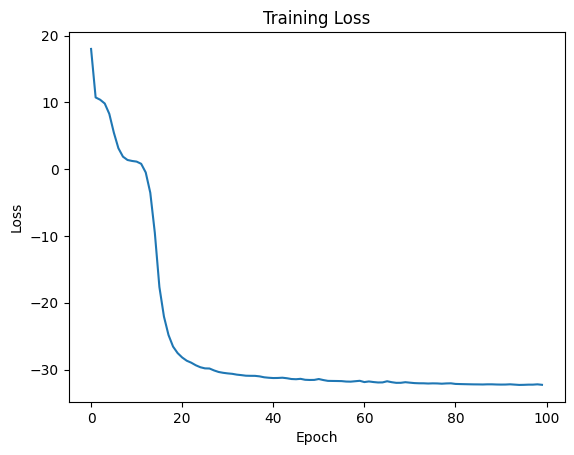

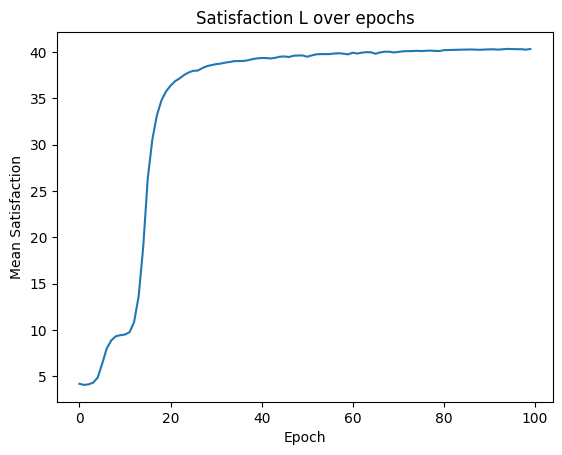

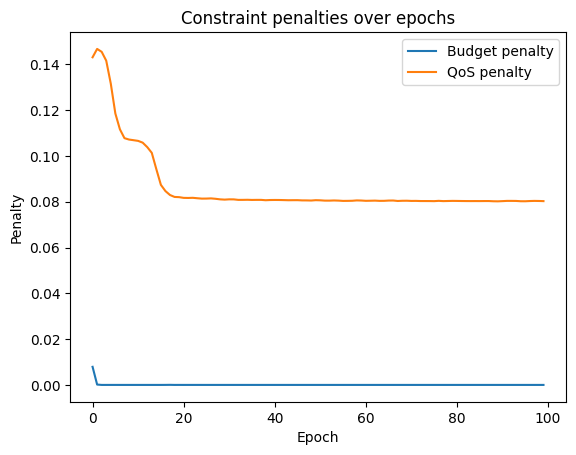

In [594]:
import matplotlib.pyplot as plt

df_logs = pd.DataFrame(logs)
x = range(0, EPOCHS)
plt.figure()
plt.plot(x, df_logs["loss"])
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

#Satisfaction
plt.figure()
plt.plot(x, df_logs["sumL"])
plt.xlabel("Epoch"); plt.ylabel("Mean Satisfaction")
plt.title("Satisfaction L over epochs")
plt.show()

#Penalty
plt.figure()
plt.plot(x, df_logs["budget"], label="Budget penalty")
plt.plot(x, df_logs["qos"], label="QoS penalty")
plt.xlabel("Epoch"); plt.ylabel("Penalty")
plt.title("Constraint penalties over epochs")
plt.legend()
plt.show()


In [575]:
@torch.no_grad()
def count_violations_on_loader(policy, loader, threshold=1e-6, eps=1e-30):
    policy.eval()
    if not isinstance(loader, list):
        loader = list(loader)

    def _to_tensor(x, device, dtype=torch.float32):
        if isinstance(x, torch.Tensor):
            return x.to(device=device, dtype=dtype)
        if hasattr(x, "values"): 
            x = x.values
        return torch.tensor(x, device=device, dtype=dtype)

    users = 0
    budget_cnt = 0
    qos_cnt = 0
    any_cnt = 0
    both_cnt = 0
    scen_with_any = 0
    batches = 0

    for batch, aux_list in loader:
        device = next(policy.parameters()).device
        batch = batch.to(device)
        w_rx_all, p_f_all, a_all = policy(batch)  # (Nu, K+1), (Nu,F), (Nu,)
        user_batch = batch["user"].batch          # (Nu,)
        gids = torch.unique_consecutive(user_batch)
        assert len(gids) == len(aux_list), "aux_list không khớp số scenario trong batch (hetero)."

        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            w_rx = w_rx_all[mask]  # (N_i, K+1)
            p_f  = p_f_all[mask]   # (N_i, F)
            a    = a_all[mask]     # (N_i,)

            # --- lấy aux và đưa lên device ---
            aux_i = aux_list[s_idx]
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux_i.items()}

            # --- đồng bộ key cũ/mới ---
            g_iL = aux_i.get("g_iL", aux_i.get("h_iL"))     # (N_i,)
            g_ik = aux_i.get("g_ik", aux_i.get("h_ik"))     # (N_i,K)
            Pmax = aux_i.get("Pmax", aux_i.get("Pmax_users"))
            Ci   = aux_i.get("Ci", None)
            Lthr = aux_i.get("Lthr", None)
            if Ci is None or Lthr is None:
                # fallback nếu aux chứa user_df (DataFrame)
                user_df = aux_i.get("user_df", None)
                if user_df is None:
                    raise KeyError("Cần Ci & Lthr trong aux hoặc aux['user_df'].")
                Ci   = user_df["Ci"].to(device=device)
                Lthr = user_df["Lthr"].to(device=device)

            noise = aux_i["noise"].squeeze()
            SL = aux_i["SL"].squeeze()
            SW = aux_i["SW"].squeeze()
            cprice = aux_i["cprice"].squeeze()

            # ép kiểu
            g_iL = _to_tensor(g_iL, device)
            g_ik = _to_tensor(g_ik, device)
            Pmax = _to_tensor(Pmax, device)
            Ci   = _to_tensor(Ci,   device)
            Lthr = _to_tensor(Lthr, device)

            # --- tính các đại lượng ---
            wL = w_rx[:, 0]
            wW = w_rx[:, 1:]
            # desired gain
            h_des = wL * g_iL + (wW * g_ik).sum(dim=1)  # (N_i,)

            # interference matrix Hbar[a,b]
            term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)           # (N_i,N_i)
            term2 = wW @ g_ik.transpose(0,1)                      # (N_i,N_i)
            Hbar  = term1 + term2
            Hbar  = Hbar - torch.diag_embed(torch.diag(Hbar))

            # power and SINR expected over subbands
            P   = a * Pmax
            num = P * h_des
            SINR = torch.zeros_like(num)
            Fbands = p_f.size(1)
            for f in range(Fbands):
                S_f = p_f[:, f] * P
                denom = Hbar @ S_f + noise
                SINR += p_f[:, f] * (num / (denom + eps))

            rate = torch.log2(1.0 + SINR)
            S_i  = SW + (SL - SW) * wL
            L_i  = S_i * rate

            # masks
            budget_mask = (cprice * rate * wL - Ci) > threshold
            qos_mask    = (Lthr - L_i) > 0
            any_mask    = budget_mask | qos_mask
            both_mask   = budget_mask & qos_mask

            n_i   = int(rate.numel())
            b_i   = int(budget_mask.sum().item())
            q_i   = int(qos_mask.sum().item())
            any_i = int(any_mask.sum().item())
            both_i= int(both_mask.sum().item())

            users      += n_i
            budget_cnt += b_i
            qos_cnt    += q_i
            any_cnt    += any_i
            both_cnt   += both_i
            if any_i > 0:
                scen_with_any += 1

        

        batches += 1

    return {
        "users": users,
        "budget_violations": budget_cnt,
        "qos_violations": qos_cnt,
        "any_violations": any_cnt,
        "both_violations": both_cnt,
        "scenarios_with_any_violation": scen_with_any,
        "budget_rate": budget_cnt / max(users, 1),
        "qos_rate": qos_cnt / max(users, 1),
        "any_rate": any_cnt / max(users, 1),
        "both_rate": both_cnt / max(users, 1),
        "batches": batches,
    }

In [595]:
summary = count_violations_on_loader(model, batches)
print(summary)

{'users': 5000, 'budget_violations': 791, 'qos_violations': 1698, 'any_violations': 2489, 'both_violations': 0, 'scenarios_with_any_violation': 978, 'budget_rate': 0.1582, 'qos_rate': 0.3396, 'any_rate': 0.4978, 'both_rate': 0.0, 'batches': 16}


# Thedual-objectiveproblem

In [478]:
import math
from typing import Iterable, List, Optional
import torch
from torch.optim import Optimizer

class MTAdam(Optimizer):
    def __init__(
        self,
        params: Iterable[torch.nn.Parameter],
        lr: float = 1e-3,
        betas=(0.9, 0.999, 0.9),   # (beta1, beta2, beta3)
        eps: float = 1e-8,
        weight_decay: float = 0.0, # L2 (không decoupled) để khớp bản gốc
        amsgrad: bool = False,
        num_terms: Optional[int] = None,
    ):
        if num_terms is None or num_terms <= 0:
            raise ValueError("MTAdam: num_terms (số loss) phải > 0")
        b1, b2, b3 = betas
        if not (0.0 < b1 < 1.0 and 0.0 < b2 < 1.0 and 0.0 < b3 < 1.0):
            raise ValueError("MTAdam: betas phải nằm trong (0,1)")
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        num_terms=num_terms)
        super().__init__(params, defaults)

        # Khởi tạo state
        for group in self.param_groups:
            I = group['num_terms']
            for p in group['params']:
                if not p.requires_grad:
                    continue
                state = self.state[p]
                state['step'] = 0
                # m_i, v_i, vhat_max (AMSGrad)
                state['exp_avg']    = [torch.zeros_like(p.data) for _ in range(I)]
                state['exp_avg_sq'] = [torch.zeros_like(p.data) for _ in range(I)]
                if amsgrad:
                    state['max_exp_avg_sq'] = [torch.zeros_like(p.data) for _ in range(I)]
                # n_i: EMA(||g||) per-loss (scalar per-param)
                # dùng tensor trên cùng device với p
                state['n_mag'] = [p.data.new_tensor(1.0) for _ in range(I)]

    @torch.no_grad()
    def step_from_losses(self, losses: List[torch.Tensor], ranks: Optional[List[float]] = None, retain_graph: bool = False):
        if len(self.param_groups) == 0:
            return
        group = self.param_groups[0]
        I = group['num_terms']
        if I != len(losses):
            raise ValueError(f"MTAdam: num_terms={I} nhưng nhận {len(losses)} losses")
        if ranks is None:
            ranks = [1.0] * I

        lr = group['lr']
        beta1, beta2, beta3 = group['betas']
        eps = group['eps']
        wd = group['weight_decay']
        amsgrad = group['amsgrad']

        # Gom params (theo thứ tự cố định)
        params: List[torch.nn.Parameter] = []
        for g in self.param_groups:
            for p in g['params']:
                if p.requires_grad:
                    params.append(p)
        if not params:
            return
        grads_per_loss: List[List[Optional[torch.Tensor]]] = []
        for i, Li in enumerate(losses):
            grads_i = torch.autograd.grad(
                Li, params, retain_graph=True if (retain_graph or i < len(losses)-1) else False,
                allow_unused=True, create_graph=False
            )
            grads_per_loss.append(list(grads_i))

        # Cập nhật từng param
        for p_idx, p in enumerate(params):
            state = self.state[p]
            state['step'] += 1
            t = state['step']

            # 1) Cập nhật n_i = EMA(||g||) và tìm anchor (loss đầu tiên có norm>0)
            n_vals = []
            nonzero_first = None
            for i in range(I):
                gi = grads_per_loss[i][p_idx]
                if gi is None:
                    n_vals.append(state['n_mag'][i])
                    continue
                norm_i = torch.linalg.vector_norm(gi.detach())
                state['n_mag'][i] = beta3 * state['n_mag'][i] + (1.0 - beta3) * norm_i
                n_vals.append(state['n_mag'][i])
                if (nonzero_first is None) and (norm_i > 1e-12):
                    nonzero_first = i
            # chọn anchor
            anchor = 0 if nonzero_first is None else nonzero_first
            n_anchor = n_vals[anchor] + 1e-32

            # 2) Chuẩn hoá & scale theo ranks
            scaled_grads = []
            for i in range(I):
                gi = grads_per_loss[i][p_idx]
                if gi is None:
                    scaled_grads.append(None)
                else:
                    denom = n_vals[i] + 1e-32
                    scaled_grads.append(ranks[i] * (n_anchor / denom) * gi)

            # 3) Moments cho từng loss (m_i, v_i) + bias-correct riêng
            m_hats, v_hats, step_sizes, denoms_i = [], [], [], []
            for i in range(I):
                gi = scaled_grads[i]
                m = state['exp_avg'][i]
                v = state['exp_avg_sq'][i]
                if gi is not None:
                    # L2 (không decoupled) — đúng bản gốc: thêm vào grad
                    if wd != 0.0:
                        gi = gi.add(p.data, alpha=wd)
                    m.mul_(beta1).add_(gi, alpha=1.0 - beta1)
                    v.mul_(beta2).addcmul_(gi, gi, value=1.0 - beta2)

                # bias-correct
                m_hat = m / (1.0 - beta1**t)
                v_hat = v / (1.0 - beta2**t)
                if amsgrad:
                    vmax = state['max_exp_avg_sq'][i]
                    torch.maximum(vmax, v_hat, out=vmax)
                    v_hat = vmax  # dùng max cho AMSGrad

                # giữ lại để kết hợp ở cuối
                m_hats.append(m_hat)
                v_hats.append(v_hat)
                step_sizes.append(lr / (1.0 - beta1**t))

                state['exp_avg'][i] = m
                state['exp_avg_sq'][i] = v

            # 4) denom chung = sqrt(max_i vhat_i) + eps
            vhat_stack = torch.stack(v_hats, dim=0)
            denom_common = torch.sqrt(torch.amax(vhat_stack, dim=0)) + eps

            # 5) tổng hợp update = sum_i ( step_size_i * mhat_i / denom_common )
            update = torch.zeros_like(p.data)
            for i in range(I):
                update.add_(m_hats[i] / denom_common, alpha=step_sizes[i])

            # 6) apply
            p.data.add_(update, alpha=-1.0)

    # tiện alias
    step_with_multitask_grads = step_from_losses


In [517]:
def _compute_per_scenario_metrics(w_rx, p_f, a, aux, tau: float = 0.2):
    g_iL = aux.get("g_iL", aux.get("h_iL"))      #
    g_ik = aux.get("g_ik", aux.get("h_ik"))      
    Pmax = aux.get("Pmax", aux.get("Pmax_users"))
    Ci   = aux["Ci"]                              
    Lthr = aux["Lthr"]                          
    noise= aux["noise"]            
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]
    wL = w_rx[:, 0]              
    wW = w_rx[:, 1:]             
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                     
    Hbar  = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.t() 
    Hbar.fill_diagonal_(0.0)

    P = a * Pmax                                                   
    num = P * h_des
    SINR = torch.zeros_like(num)
    Fbands = p_f.size(1)
    for f in range(Fbands):
        S_f = p_f[:, f] * P                                    
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + 1e-30))

    rate = torch.log2(1.0 + SINR)                            
    S_i  = SW + (SL - SW) * wL
    L_i  = S_i * rate       
    pen_budget = F.relu(cprice * rate * wL - Ci).sum()
    pen_qos    = F.relu(Lthr - L_i).mean()

    Q_soft_mean = torch.sigmoid((L_i - Lthr) / tau).mean()
    Q_hard_cnt  = (L_i >= Lthr).sum().item()
    N_i = int(L_i.numel())
    return L_i, Q_soft_mean, Q_hard_cnt, N_i, pen_budget, pen_qos

In [518]:
import torch
import torch.nn.functional as F

def train_dual_MTAdam(
    policy: torch.nn.Module,
    batches,                       # list of (HeteroDataBatch, aux_list)
    mtadam,                        # MTAdam(num_terms=2)
    lambda_budget: float = 1.0,
    lambda_qos: float = 1.0,
    tau: float = 0.2,
):
    device = next(policy.parameters()).device
    policy.train()

    ep_lossL = ep_lossQ = 0.0
    ep_sumL  = ep_Qrate = 0.0
    ep_penB  = ep_penQ  = 0.0
    num_batches = 0

    for batch, aux_list in batches:
        batch = batch.to(device)
        w_rx_all, p_f_all, a_all = policy(batch)         
        user_batch = batch["user"].batch             
        gids = torch.unique_consecutive(user_batch)    
        if len(gids) != len(aux_list):
            continue

        L_all, Qsoft_list = [], []
        penB_list, penQ_list = [], []
        hard_total, users_total = 0, 0
        for s_idx, g in enumerate(gids.tolist()):
            mask = (user_batch == g)
            if mask.sum() == 0:
                continue

            w_rx = w_rx_all[mask]
            p_f  = p_f_all[mask]
            a    = a_all[mask]

            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}

            L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx, p_f, a, aux_i, tau=tau
            )
            if L_i.numel() == 0:
                continue

            L_all.append(L_i)
            Qsoft_list.append(Q_soft_mean)
            penB_list.append(penB)
            penQ_list.append(penQ)
            hard_total  += Q_hard_cnt
            users_total += N_i

        if len(L_all) == 0:
            continue
        sumL       = torch.stack([L.sum() for L in L_all]).mean()
        Q_soft     = torch.stack(Qsoft_list).mean()
        Q_hard_rate= hard_total / max(users_total, 1)
        pen_budget = torch.stack(penB_list).mean()
        pen_qos    = torch.stack(penQ_list).mean()

        loss_L = -sumL + lambda_budget * pen_budget + lambda_qos * pen_qos
        loss_Q = -Q_soft
        mtadam.step_from_losses([loss_L, loss_Q])

        ep_lossL += float(loss_L.item())
        ep_lossQ += float(loss_Q.item())
        ep_sumL  += float(sumL.item())
        ep_Qrate += float(Q_hard_rate)
        ep_penB  += float(pen_budget.item())
        ep_penQ  += float(pen_qos.item())
        num_batches += 1

    return {
        "loss_L":   ep_lossL / max(num_batches, 1),
        "loss_Q":   ep_lossQ / max(num_batches, 1),
        "sumL":     ep_sumL / max(num_batches, 1),
        "Q_rate":   ep_Qrate / max(num_batches, 1),
        "pen_budget": ep_penB / max(num_batches, 1),
        "pen_qos":    ep_penQ / max(num_batches, 1),
        "batches":  num_batches,
    }


In [568]:
policy = PolicyHetero(
    user_in=3,
    infra_in=1,
    hidden=256,
    Fs=cfg.Fs,
    K_plus_1=cfg.K + 1
)
mtadam = MTAdam(policy.parameters(), lr=5e-4, weight_decay=1e-3,
                num_terms=2, 
                betas=(0.9, 0.9, 0.6)) 

In [569]:
logs = []
EPOCHS = 100
for ep in range(1, EPOCHS+1):
    ep_log = train_dual_MTAdam(
        policy, batches, mtadam,
        lambda_budget=1000.0, lambda_qos=100.0, tau = 0.2
    )
    ep_log["epoch"] = ep
    logs.append(ep_log)
    print(f"[Ep {ep:03d}] sumL={ep_log['sumL']:.4f} | Q%={100*ep_log['Q_rate']:.2f}% "
          f"| loss_L={ep_log['loss_L']:.4f} | loss_Q={ep_log['loss_Q']:.4f} "
          f"| pen(B)={ep_log['pen_budget']:.6f} | pen(Q)={ep_log['pen_qos']:.4f}")


[Ep 001] sumL=4.9140 | Q%=43.20% | loss_L=12.7098 | loss_Q=-0.5271 | pen(B)=0.004201 | pen(Q)=0.1342
[Ep 002] sumL=8.7093 | Q%=54.98% | loss_L=1.6792 | loss_Q=-0.6224 | pen(B)=0.000000 | pen(Q)=0.1039
[Ep 003] sumL=17.2885 | Q%=61.50% | loss_L=-8.2317 | loss_Q=-0.6781 | pen(B)=0.000000 | pen(Q)=0.0906
[Ep 004] sumL=25.5396 | Q%=64.74% | loss_L=-17.2329 | loss_Q=-0.7066 | pen(B)=0.000000 | pen(Q)=0.0831
[Ep 005] sumL=27.2190 | Q%=64.54% | loss_L=-18.8705 | loss_Q=-0.7052 | pen(B)=0.000000 | pen(Q)=0.0835
[Ep 006] sumL=27.9951 | Q%=65.01% | loss_L=-19.7414 | loss_Q=-0.7087 | pen(B)=0.000000 | pen(Q)=0.0825
[Ep 007] sumL=28.5808 | Q%=64.95% | loss_L=-20.3149 | loss_Q=-0.7094 | pen(B)=0.000000 | pen(Q)=0.0827
[Ep 008] sumL=29.4531 | Q%=65.47% | loss_L=-21.3154 | loss_Q=-0.7135 | pen(B)=0.000000 | pen(Q)=0.0814
[Ep 009] sumL=29.9115 | Q%=65.32% | loss_L=-21.7391 | loss_Q=-0.7128 | pen(B)=0.000000 | pen(Q)=0.0817
[Ep 010] sumL=30.1278 | Q%=65.51% | loss_L=-21.9989 | loss_Q=-0.7143 | pen(B)=0

In [596]:
summary2 = count_violations_on_loader(policy, batches)
print(summary2)

{'users': 5000, 'budget_violations': 0, 'qos_violations': 1698, 'any_violations': 1698, 'both_violations': 0, 'scenarios_with_any_violation': 978, 'budget_rate': 0.0, 'qos_rate': 0.3396, 'any_rate': 0.3396, 'both_rate': 0.0, 'batches': 16}


# Heuristic

In [ ]:
def greedy_assignment(C_i, K):
    X_iL = np.zeros(len(C_i), dtype=int)
    ap_idx = np.full(len(C_i), -1, dtype=int)  # -1 nếu LTE

    for i in range(len(C_i)):
        if C_i[i] > 0:
            X_iL[i] = 1
            ap_idx[i] = -1
        else:
            ap_idx[i] = random.randint(0, K-1)
            X_iL[i] = 0
    return X_iL, ap_idx


def inference_from_model(model, batches, device):
    model.eval()
    w_rx_all = []
    p_f_all = []
    a_all = []
    for batch, aux_list in batches:
        batch = batch.to(device)
        w_rx, p_f, a = model(batch.x, batch.edge_index, batch.edge_weight)
        w_rx_all.append(w_rx)
        p_f_all.append(p_f)
        a_all.append(a)

    w_rx_all = torch.cat(w_rx_all, dim = 0)
    p_f_all = torch.cat(p_f_all, dim = 0)
    a_all = torch.cat(a_all, dim = 0)

    return w_rx_all, p_f_all, a_all

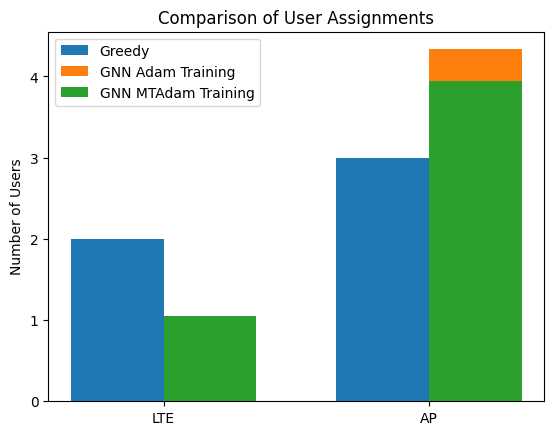

In [ ]:
# assign distribution
num_test = 200
start_seed = 7
X_iL_greedy_count = 0
X_iL_model_count = 0
X_iL_policy_count = 0
for i in range(num_test):
    seed =  start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize=True)
    X_iL_greedy, ap_idx_greedy = greedy_assignment(aux_i["Ci"].numpy(), cfg.K)

    w_rx_all, p_f_all, a_all = model(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))
    X_iL_model = w_rx_all.max(dim = 1).indices.cpu().numpy() == 0

    w_rx_policy, p_f_policy, a_policy = policy(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))
    X_iL_policy = w_rx_policy.max(dim = 1).indices.cpu().numpy() == 0

    X_iL_greedy_count += np.sum(X_iL_greedy) 
    X_iL_model_count += np.sum(X_iL_model)    
    X_iL_policy_count += np.sum(X_iL_policy)    
    
labels = ['LTE', 'AP']
greedy_values = [X_iL_greedy_count / num_test, cfg.N - X_iL_greedy_count / num_test]  
model_values = [X_iL_model_count / num_test, cfg.N - X_iL_model_count/num_test]
policy_values = [X_iL_policy_count / num_test, cfg.N - X_iL_policy_count/num_test]


x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, greedy_values, width, label='Greedy')
bars2 = ax.bar(x + width/2, model_values, width, label='GNN Adam Training')
bars3 = ax.bar(x + width/2, policy_values, width, label='GNN MTAdam Training')

ax.set_ylabel('Number of Users')
ax.set_title('Comparison of User Assignments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


plt.show()


In [599]:

num_test = 200
start_seed = 7
mean_L_model_total = 0
mean_L_greedy_total = 0
mean_L_adam_total = 0
budget_penalty_model_total = 0
budget_penalty_greedy_total = 0
budget_penalty_adam_total = 0
qos_penalty_model_total = 0
qos_penalty_greedy_total = 0
qos_penalty_adam_total = 0
for i in range(num_test):
    seed =  start_seed + i
    df_i, data_i, aux_i = generate_dataset_bipartite(cfg, seed=seed, standardize = True)
    ### model inference
    w_rx_model, p_f_model, a_model = model(data_i)
    # X_iL_model = w_rx_all.max(dim = 1).indices.cpu().numpy() == 0
    mean_L_model, penalties_model = objective_total_satisfaction(w_rx_model, p_f_model, a_model, aux_i)
    mean_L_model_total += mean_L_model.item()
    budget_penalty_model_total += penalties_model["budget"].item()
    qos_penalty_model_total += penalties_model["qos"].item()


    ### model mtadam inference
    w_rx_adam, p_f_adam, a_adam = policy(data_i)
    # X_iL_model = w_rx_all.max(dim = 1).indices.cpu().numpy() == 0
    mean_L_adam, penalties_adam = objective_total_satisfaction(w_rx_adam, p_f_adam, a_adam, aux_i)
    mean_L_adam_total += mean_L_adam.item()
    budget_penalty_adam_total += penalties_adam["budget"].item()
    qos_penalty_adam_total += penalties_adam["qos"].item()

    ### greedy assignment
    X_iL_greedy, ap_idx_greedy = greedy_assignment(aux_i["Ci"].numpy(), cfg.K)
    w_rx_greedy = torch.zeros((cfg.N, cfg.K + 1), dtype=torch.float32, device=device)  
    p_f_greedy  = torch.zeros((cfg.N, cfg.Fs), dtype=torch.float32, device=device)     
    a_greedy    = torch.full((cfg.N,), cfg.P_max, dtype=torch.float32, device=device)  

    lte_mask = (aux_i["Ci"] > 0)
    w_rx_greedy[lte_mask, 0] = 1
    non_lte_mask = ~lte_mask
    ap_idx = torch.randint(0, cfg.K, (non_lte_mask.sum(),), device=device)
    w_rx_greedy[non_lte_mask, 1 + ap_idx] = 1

    subband_idx = torch.randint(0, cfg.Fs, (cfg.N,), device=device)
    # a = torch.sigmoid(torch.randn(N, device=device))
    p_f_greedy[torch.arange(cfg.N, device=device), subband_idx] = 1
    mean_L_greedy, penalties_greedy = objective_total_satisfaction(w_rx_greedy, p_f_greedy, a_greedy, aux_i)

    mean_L_greedy_total += mean_L_greedy.item()
    budget_penalty_greedy_total += penalties_greedy["budget"].item()
    qos_penalty_greedy_total += penalties_greedy["qos"].item()


mean_L_model_avg = mean_L_model_total / num_test
mean_L_greedy_avg = mean_L_greedy_total / num_test
mean_L_adam_avg = mean_L_adam_total / num_test
budget_penalty_model_avg = budget_penalty_model_total / num_test
budget_penalty_greedy_avg = budget_penalty_greedy_total / num_test
budget_penalty_adam_avg = budget_penalty_adam_total / num_test
qos_penalty_model_avg = qos_penalty_model_total / num_test
qos_penalty_greedy_avg = qos_penalty_greedy_total / num_test
qos_penalty_adam_avg = qos_penalty_adam_total / num_test


print(f"GNN Adam Mean Satisfaction: {mean_L_model_avg:.4f}")
print(f"GNN MTAdam Mean Satisfaction: {mean_L_adam_avg:.4f}")
print(f"Greedy Mean Satisfaction: {mean_L_greedy_avg:.4f}")

print(f"GNN Adam Budget Penalty: {budget_penalty_model_avg:.4f}")
print(f"Greedy Budget Penalty: {budget_penalty_greedy_avg:.4f}")
print(f"GNN MTAdam Budget Penalty: {budget_penalty_adam_avg:.4f}")

print(f"GNN Adam QoS Penalty: {qos_penalty_model_avg:.4f}")
print(f"Greedy QoS Penalty: {qos_penalty_greedy_avg:.4f}")
print(f"GNN MTAdam QoS Penalty: {qos_penalty_adam_avg:.4f}")


labels = ['GNN Adam Training', 'Greedy', 'GNN MTAdam Training']
mean_L_values = [mean_L_model_avg, mean_L_greedy_avg, mean_L_adam_avg]

# Vẽ biểu đồ so sánh Budget Penalty
budget_values = [budget_penalty_model_avg, budget_penalty_greedy_avg, budget_penalty_adam_avg]

# Vẽ biểu đồ so sánh QoS Penalty
qos_values = [qos_penalty_model_avg, qos_penalty_greedy_avg, qos_penalty_adam_avg]

# Vẽ các biểu đồ
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
color=['blue', 'orange', 'red']
# So sánh Mean Satisfaction (L_i)
ax[0].bar(labels, mean_L_values, color=color)
ax[0].set_ylabel('Mean Satisfaction (L_i)')
ax[0].set_title('Comparison of Mean Satisfaction (L)')

# So sánh Budget Penalty
ax[1].bar(labels, budget_values, color=color)
ax[1].set_ylabel('Budget Penalty')
ax[1].set_title('Comparison of Budget Penalty')

# So sánh QoS Penalty
ax[2].bar(labels, qos_values, color=color)
ax[2].set_ylabel('QoS Penalty')
ax[2].set_title('Comparison of QoS Penalty')

plt.tight_layout()
plt.show()

AttributeError: 'NodeStorage' object has no attribute 'batch'

Greedy Q (Users satisfying both QoS and Budget): 1.7100
Model Q (Users satisfying both QoS and Budget): 3.9500


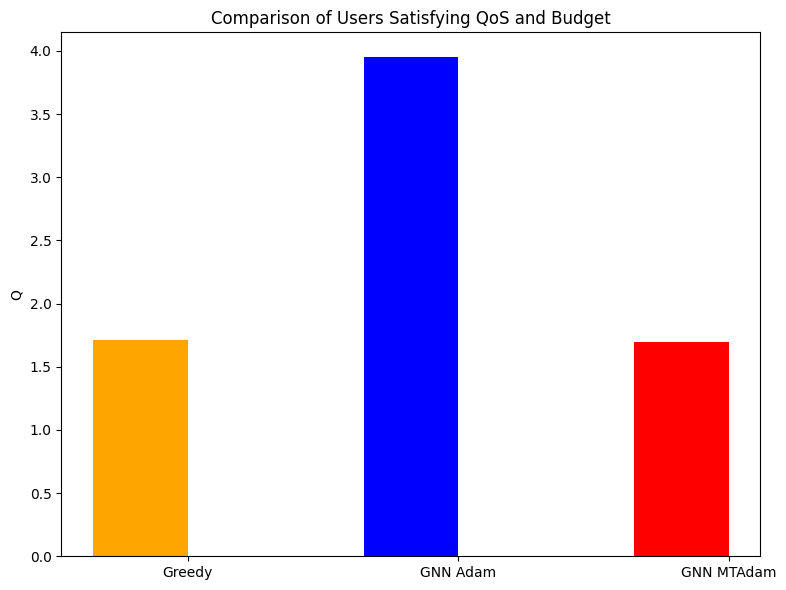

In [ ]:
def compute_L_and_violations(w_rx, p_f, a, aux, threshold=1e-6):
    device = w_rx.device
    aux = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}

    # Unpack
    g_iL   = aux["g_iL"]        # (N,)
    g_ik   = aux["g_ik"]        # (N,K)
    Pmax   = aux["Pmax"]        # (N,)
    Ci     = aux["Ci"]          # (N,)
    Lthr   = aux["Lthr"]        # (N,)
    noise  = aux["noise"]       # scalar
    SL     = aux["SL"]; SW = aux["SW"]
    cprice = aux["cprice"]
    wL = w_rx[:, 0]       
    wW = w_rx[:, 1:]         
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                    # (N,)
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)                   # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                              # (N,N)
    Hbar = term1 + term2
    Hbar.fill_diagonal_(0.0)
    P = a * Pmax                                                 # (N,)
    num = P * h_des                                              # (N,)
    SINR = torch.zeros_like(num)
    Fs = p_f.size(1)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                      # (N,)
        denom = Hbar @ S_f + noise                               # (N,)
        SINR += p_f[:, f] * (num / (denom + 1e-30))

    rate = torch.log2(1.0 + SINR)       
    S_i = SW + (SL - SW) * wL                               
    L_i = S_i * rate                  
    qos_violation_mask = (L_i < Lthr)                           # (N,)
    budget_violation_mask = (cprice * rate * wL - Ci) > 0      # (N,)

    return L_i, qos_violation_mask, budget_violation_mask

num_test = 200
start_seed = 7
greedy_Q_count = 0
model_Q_count = 0
policy_Q_count = 0


for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset(cfg, seed=seed, standardize=True)

    # ----------- Model Inference -----------
    w_rx_model, p_f_model, a_model = model(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))

    # Tính toán \( L_i \) và vi phạm QoS, Budget cho Model
    L_i_model, qos_mask_model, budget_mask_model = compute_L_and_violations(w_rx_model, p_f_model, a_model, aux_i)

    # Kiểm tra vi phạm QoS và Budget cho Model
    model_qos_mask = (L_i_model >= aux_i["Lthr"].to(device))  # Kiểm tra QoS
    model_budget_mask = (a_model * aux_i["Pmax"].to(device) * w_rx_model[:, 0] - aux_i["Ci"].to(device)) <= 0  # Kiểm tra Budget
    model_Q_count += torch.sum(model_qos_mask & model_budget_mask).item()  # Số người thỏa mãn cả QoS và Budget


    # MTAdam
    w_rx_policy, p_f_policy, a_policy = policy(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))

    # Tính toán \( L_i \) và vi phạm QoS, Budget cho Model
    L_i_policy, qos_mask_policy, budget_mask_policy = compute_L_and_violations(w_rx_policy, p_f_policy, a_policy, aux_i)

    # Kiểm tra vi phạm QoS và Budget cho Model
    policy_qos_mask = (L_i_policy >= aux_i["Lthr"].to(device))  #
    policy_budget_mask = (a_policy * aux_i["Pmax"].to(device) * w_rx_policy[:, 0] - aux_i["Ci"].to(device)) <= 0  # Kiểm tra Budget
    policy_Q_count += torch.sum(policy_qos_mask & policy_budget_mask).item()

    # ----------- Greedy Assignment -----------
    X_iL_greedy, ap_idx_greedy = greedy_assignment(aux_i["Ci"].numpy(), cfg.K)

    w_rx_greedy = torch.zeros((cfg.N, cfg.K + 1), dtype=torch.float32, device=device)  
    p_f_greedy  = torch.zeros((cfg.N, cfg.Fs), dtype=torch.float32, device=device)     
    a_greedy    = torch.full((cfg.N,), cfg.P_max, dtype=torch.float32, device=device)  

    lte_mask = (aux_i["Ci"] > 0)
    w_rx_greedy[lte_mask, 0] = 1
    non_lte_mask = ~lte_mask
    ap_idx = torch.randint(0, cfg.K, (non_lte_mask.sum(),), device=device)
    w_rx_greedy[non_lte_mask, 1 + ap_idx] = 1

    subband_idx = torch.randint(0, cfg.Fs, (cfg.N,), device=device)
    p_f_greedy[torch.arange(cfg.N, device=device), subband_idx] = 1

    # Tính toán \( L_i \) và vi phạm QoS, Budget cho Greedy
    L_i_greedy, qos_mask_greedy, budget_mask_greedy = compute_L_and_violations(w_rx_greedy, p_f_greedy, a_greedy, aux_i)

    # Kiểm tra vi phạm QoS và Budget cho Greedy
    greedy_qos_mask = (L_i_greedy >= aux_i["Lthr"].to(device))  # Kiểm tra QoS
    greedy_budget_mask = (a_greedy * aux_i["Pmax"].to(device) * w_rx_greedy[:, 0] - aux_i["Ci"].to(device)) <= 0  # Kiểm tra Budget
    greedy_Q_count += torch.sum(greedy_qos_mask & greedy_budget_mask).item()  # Số người thỏa mãn cả QoS và Budget

# Tính tỉ lệ số người đạt cả QoS và Budget cho Greedy và Model
greedy_Q_rate = greedy_Q_count / (num_test )
model_Q_rate = model_Q_count / (num_test)
policy_Q_rate = policy_Q_count / (num_test)

# In kết quả
print(f"Greedy Q (Users satisfying both QoS and Budget): {greedy_Q_rate:.4f}")
print(f"Model Q (Users satisfying both QoS and Budget): {model_Q_rate:.4f}")

# ---------------------- Vẽ biểu đồ so sánh ----------------------

# Vẽ biểu đồ so sánh Q (tỉ lệ người thỏa mãn cả QoS và Budget)
labels = ['Greedy', 'GNN Adam','GNN MTAdam']
colors = ['orange', 'blue','red']
Q_values = [greedy_Q_rate, model_Q_rate, policy_Q_rate]

x = np.arange(len(labels))  # Vị trí các cột trên trục x
width = 0.35  # Độ rộng cột

fig, ax = plt.subplots(figsize=(8, 6))

# Vẽ biểu đồ so sánh Q
ax.bar(x - width/2, Q_values, width, label=labels, color = colors)

ax.set_ylabel('Q')
ax.set_title('Comparison of Users Satisfying QoS and Budget')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()

plt.tight_layout()
plt.show()

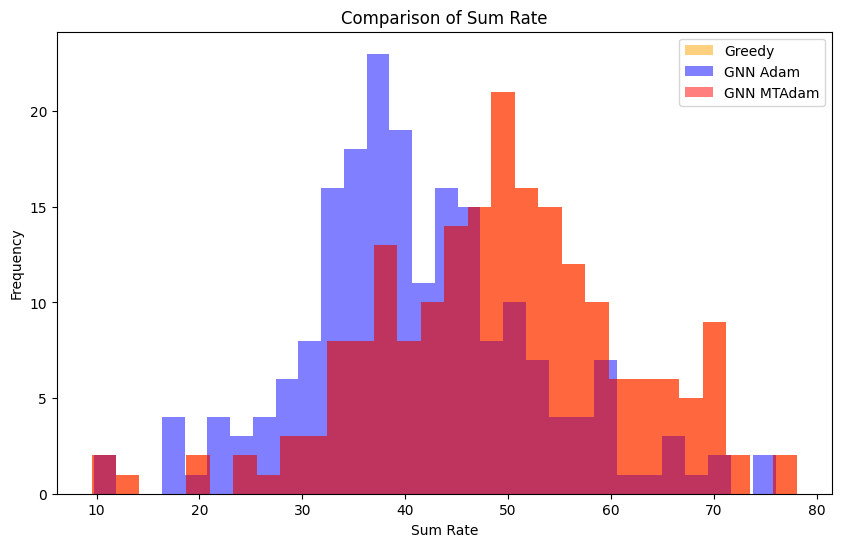

In [ ]:
def compute_SINR(w_rx, p_f, a, aux):
    device = w_rx.device
    aux = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}

    # Unpack
    g_iL   = aux["g_iL"]        
    g_ik   = aux["g_ik"]       
    Pmax   = aux["Pmax"]      
    Ci     = aux["Ci"]         
    Lthr   = aux["Lthr"]       
    noise  = aux["noise"]   
    SL     = aux["SL"]; SW = aux["SW"]
    cprice = aux["cprice"]
    wL = w_rx[:, 0]       
    wW = w_rx[:, 1:]         
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)               
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)                  
    term2 = wW @ g_ik.transpose(0,1)                           
    Hbar = term1 + term2
    Hbar.fill_diagonal_(0.0)
    P = a * Pmax                                               
    num = P * h_des                                         
    SINR = torch.zeros_like(num)
    Fs = p_f.size(1)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                  
        denom = Hbar @ S_f + noise                          
        SINR += p_f[:, f] * (num / (denom + 1e-30))

    rate = torch.log2(1.0 + SINR)  
    return rate

num_test = 200
start_seed = 7
greedy_sum_rate = []
model_sum_rate = []
mtadam_sum_rate = []

for i in range(num_test):
    seed = start_seed + i
    df_i, data_i, aux_i = generate_dataset(cfg, seed=seed, standardize=True)

    # ----------- GNN Adam Inference -----------
    w_rx_model, p_f_model, a_model = model(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))
    rate_model = compute_SINR(w_rx_model, p_f_model, a_model, aux_i)
    sum_rate_model = torch.sum(rate_model).cpu().detach().numpy()  
    model_sum_rate.append(sum_rate_model)

    # ----------- GNN MTAdam Inference -----------
    w_rx_mtadam, p_f_mtadam, a_mtadam = policy(data_i.x.to(device), data_i.edge_index.to(device), data_i.edge_weight.to(device))
    rate_mtadam = compute_SINR(w_rx_mtadam, p_f_mtadam, a_mtadam, aux_i)
    sum_rate_mtadam = torch.sum(rate_mtadam).cpu().detach().numpy() 
    mtadam_sum_rate.append(sum_rate_mtadam)

    # ----------- Greedy Assignment -----------
    X_iL_greedy, ap_idx_greedy = greedy_assignment(aux_i["Ci"].numpy(), cfg.K)

    w_rx_greedy = torch.zeros((cfg.N, cfg.K + 1), dtype=torch.float32, device=device)  
    p_f_greedy  = torch.zeros((cfg.N, cfg.Fs), dtype=torch.float32, device=device)     
    a_greedy    = torch.full((cfg.N,), cfg.P_max, dtype=torch.float32, device=device)  

    lte_mask = (aux_i["Ci"] > 0)
    w_rx_greedy[lte_mask, 0] = 1
    non_lte_mask = ~lte_mask
    ap_idx = torch.randint(0, cfg.K, (non_lte_mask.sum(),), device=device)
    w_rx_greedy[non_lte_mask, 1 + ap_idx] = 1

    subband_idx = torch.randint(0, cfg.Fs, (cfg.N,), device=device)
    p_f_greedy[torch.arange(cfg.N, device=device), subband_idx] = 1 
    rate_greedy = compute_SINR(w_rx_greedy, p_f_greedy, a_greedy, aux_i)
    sum_rate_greedy = torch.sum(rate_mtadam).cpu().detach().numpy()  
    greedy_sum_rate.append(sum_rate_greedy)


# greedy_sum_rate = np.concatenate(greedy_sum_rate)
# model_sum_rate = np.concatenate(model_sum_rate) 
# mtadam_sum_rate = np.concatenate(mtadam_sum_rate)

plt.figure(figsize=(10, 6))
plt.hist(greedy_sum_rate, bins=30, alpha=0.5, label='Greedy', color='orange')
plt.hist(model_sum_rate, bins=30, alpha=0.5, label='GNN Adam', color='blue')
plt.hist(mtadam_sum_rate, bins=30, alpha=0.5, label='GNN MTAdam', color='red')

plt.title('Comparison of Sum Rate')
plt.xlabel('Sum Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Save model

In [ ]:
def save_model(model,filename='model_checkpoint.pth'):
    torch.save({
        'model_state_dict': model.state_dict()
    }, filename)

In [597]:
save_model(policy, 'congest/mtadam3.pth')
save_model(model, 'congest/adam3.pth')